# Regression

Welcome! This workshop is from [TrainingDataScience.com](https://trainingdatascience.com/?utm_source=trainingdatascience&utm_medium=notebook&utm_campaign=workshop&utm_term=individual). Sign up to receive more free workshops, training and videos.

Regression is a traditional task from statistics that attempts to fit model to some input data to predict the numerical value of an output. The data is assumed to be continuous.

The goal is to be able to take a new observation and predict the output with minmal error. Some examples might be "what will next quater's profits be?" and "how many widgets do we need to stock in order to fulfil demand?".

For these questions we need real, numerical answers. But we can also use regression-like models as a
basis for classification too, and in fact there are many algorithms that are based upon this.

In [1]:
# Usual imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

In [2]:
np.random.seed(42)  # To ensure we get the same data every time.
X = 2 * np.random.rand(50, 1)
y = 8 + 6 * X + np.random.randn(50, 1)

Since we've only got a one dimensional input (that doesn't happen very often!) let's plot the data (input vs. output).

When we plot observations on an x-y scale, this is known as a _scatter plot_.

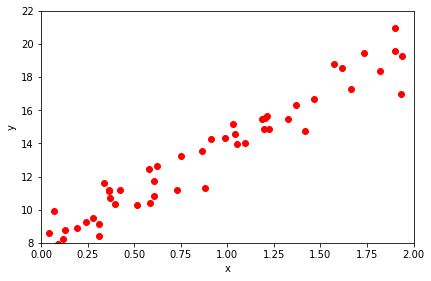

In [3]:
plt.scatter(X, y, color='red', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.axis([0, 2, 8, 22])
plt.show()

Here we can see the x and y values are clearly correlated.

## Tasks

- Try changing the colours, markers and labels of the plot (See [the scatter documentation](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html?highlight=matplotlib%20pyplot%20scatter#matplotlib-pyplot-scatter) and the [colours documentation](https://matplotlib.org/2.0.2/api/colors_api.html#module-matplotlib.colors))

## Correlation

Let's estimate that correlation..

In [4]:
cc = np.corrcoef(X, y, rowvar=0)
print("Correlation coefficient: %.2f" % cc[0,1])

Correlation coefficient: 0.97


0.97 is a huge correlation.

Now, remember that there is a closed solution to find the optimal MSE for a given data. It's called the Normal
equation.

$$
\begin{align}
\hat{w}=\left(\mathbf{x}^T\cdot\mathbf{x}\right)^{-1} \cdot \mathbf{x}^T \cdot \mathbf{y}
\end{align}
$$

Let's write that equation in numpy, then plot the result...

In [5]:
X_b = np.c_[np.ones((50, 1)), X] # add x0 = 1 to each instance (the intercept term, c, in y = mx + c)
w = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y) # Implementation of the closed form solution.
print(w) # Print the final values of the weights (intercept and slope, in this case)

[[ 8.09668927]
 [ 5.888283  ]]


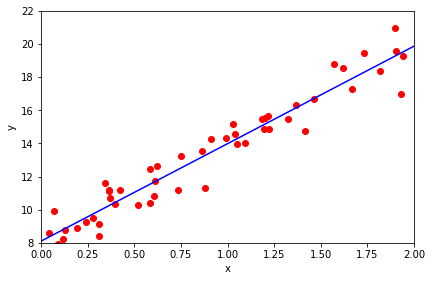

In [6]:
X_new = np.array([[0], [2]])  # Create two x points to be able to draw the line
y_predict = np.array([w[0], X_new[1]*w[1] + w[0]]) # Predict the y values for these two points.

# Plot the scatter plot
plt.scatter(X, y, color='red', marker='o')
plt.plot(X_new, y_predict, "b-")
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.axis([0, 2, 8, 22])
plt.show()

## Regression in sklearn

Now doing all this math by hand is grand, but 95% of the time, you will be more productive by using a library, especially during early phases of a data science project.

So let's reproduce the previous regression in sklearn...

In [7]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_
# Results should be the same as before...

(array([ 8.09668927]), array([[ 5.888283]]))

# Introduction to Gradient Descent

Welcome! This workshop is from [TrainingDataScience.com](https://trainingdatascience.com/?utm_source=trainingdatascience&utm_medium=notebook&utm_campaign=workshop&utm_term=individual). Sign up to receive more free workshops, training and videos.

For only a few algorithms an analytical solution exists. For example, we can use the [_Normal Equation_](https://trainingdatascience.com/workshops/linear-regression/?utm_source=trainingdatascience&utm_medium=notebook&utm_campaign=workshop&utm_term=individual) to solve a linear regression problem directly.

However, for most algorithms we rely cannot solve the problem analytically; usually because it's impossible to solve the equation. So instead we have to try something else.

_Gradient Descent_ is the idea that we can "roll down" the error curve. Let's plot an error curve for a simple model to make this more concrete.

In the model below I have some data and I am trying to estimate the _mean_. To do this I try a range of values and calculate the _mean-squared-error_ to all the observations. Note the shape of the curve.

In [8]:
# Usual imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

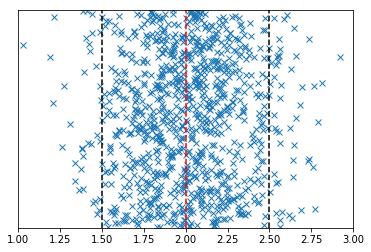

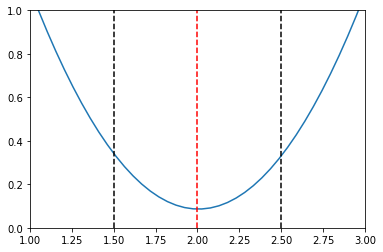

In [9]:
np.random.seed(42)  # To ensure we get the same data every time.
X = np.random.normal(loc=2, scale=0.3, size=(1000,1))
def plot_grid():
    for m in [1.5, 2.5]:
        plt.plot([m,m], [0, 1], 'k--')
    plt.plot([2,2], [0, 1], 'r--')
plt.plot(X, np.random.rand(len(X),1), 'x')
plot_grid()
plt.xlim([1,3])
plt.ylim([0,1])
plt.yticks([])
plt.show()

def mse(X, m):
    return np.sum(np.square((m - X)))/len(X)

m_values = np.linspace(1, 3, 40)
err = [mse(X, m) for m in m_values]
plt.plot(m_values, err)
plot_grid()
plt.xlim([1,3])
plt.ylim([0,1])
plt.show()

The above plots show some one-dimensional normally distributed data around 2.0. We can estimate the location of line that represents the most probable value with the mean. But imagine we couldn't calculate the mean for some reason.

What we can do is slide a range of prospective mean estimates across the data and calculate the mean squared error at each point. The value of the mean squared error for each prospective mean is shown in the second plot.

The red line represents the point at which the error is lowest. Around this point there is a convex slope.

Gradient descent works by calculating the slope of the error at a particular point. It then moves the parameters so that we move down that slope. Eventually we end up at the bottom.

So how do we calculate the gradient? With differential calculus.

## Using Gradient Descent

Below is the matrix form of the partial derivative of the mean squared error.

We can use this equation to update our prospective parameters, known as weights, and iterate towards the bottom of the error surface. (I say surface, not curve, because generally we're working in more than one dimension).

$$
\nabla_{\mathbf{w}} MSE(\mathbf{w}) = \frac{2}{m}\mathbf{x}^T \cdot (\mathbf{x} \cdot \mathbf{w} - \mathbf{y})
$$

Where \\(m\\) is the number of observations.

If we used the equation above to update our weights directly, then we actually end up jumping straight to the bottom. However, we don't generally want to move there in one hop. We want to take it slowly to ensure that we really are still going down the slope.

So instead, we weight the update by a small fraction to slow it down.


So once you have calculated the gradient using the equation above, update the current value of \\(\mathbf{w}\\) by

$$
\mathbf{w} = \mathbf{w} - \eta \nabla_{\mathbf{w}}
$$

In [10]:
np.random.seed(42)  # To ensure we get the same data every time.
X = 2 * np.random.rand(50, 1)
X_b = np.c_[np.ones((50, 1)), X] # add x0 = 1 to each instance (the intercept term, c, in y = mx + c)
y = 8 + 6 * X + np.random.randn(50, 1)

eta = 0.1 # learning rate
n_iterations = 10 # number of iterations
m=len(X) # number of samples

w = np.random.randn(2,1) # random initialization of parameters
w_old = []
for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(w) - y)
    w = w - eta * gradients
    w_old.append(w)

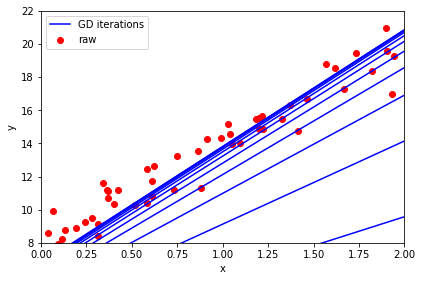

In [11]:
X_new = np.array([[0], [2]])  # Create two x points to be able to draw the line
plt.scatter(X, y,
            color='red', marker='o', label='raw')
for w_i in w_old:
    y_predict = np.array([w_i[0], X_new[1]*w_i[1] + w_i[0]])
    plt.plot(X_new, y_predict, "b-")
plt.plot(X_new, y_predict, "b-", label='GD iterations')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper left')
plt.tight_layout()
plt.axis([0, 2, 8, 22])
plt.show()

### Tasks:

- What happens when you alter the learning rate `eta`?
- What happens when you alter the number of iterations `n_iterations`?

And of course, this is already implemented in sklearn under `SGDRegressor`.
Feel free to check that this produces the same result if you wish.

# Linear Classification

Welcome! This workshop is from [TrainingDataScience.com](https://trainingdatascience.com/?utm_source=trainingdatascience&utm_medium=notebook&utm_campaign=workshop&utm_term=individual). Sign up to receive more free workshops, training and videos.

We learnt that we can use a [linear model](https://trainingdatascience.com/workshops/linear-regression/) (and possibly [gradient descent](https://trainingdatascience.com/workshops/introduction-to-gradient-descent/)) to fit a straight line to some data. To do this we minimised the mean-squared-error (often known as the optimisation/loss/cost function) between our prediction and the data.

It's also possible to slightly change the optimisation function to fit the line to separate classes. This is called linear classification.

In [12]:
# Usual imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn import datasets
from sklearn import preprocessing

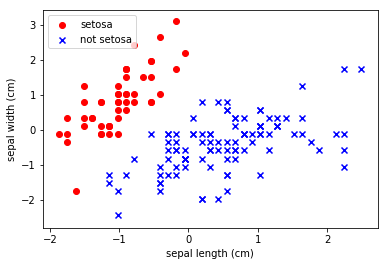

In [13]:
# import some data to play with
iris = datasets.load_iris()
feat = iris.feature_names
X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = iris.target
y[y != 0] = 1 # Only use two targets for now
colors = "bry"

# standardize
X = preprocessing.StandardScaler().fit_transform(X)

# plot data
plt.scatter(X[y == 0, 0], X[y == 0, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[y != 0, 0], X[y != 0, 1],
            color='blue', marker='x', label='not setosa')

plt.xlabel(feat[0])
plt.ylabel(feat[1])
plt.legend(loc='upper left')
plt.show()

We can visually see that there is a clear demarcation between the classes.

We theorise that we should be able to make a robust classifier with a simple linear model.

Let's do that with the classsification version of the stochastic gradient descent algorithm
from `sklearn.linear_model.SGDClassifier`...

In [14]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="squared_loss", learning_rate="constant", eta0=0.01, max_iter=10, penalty=None).fit(X, y)

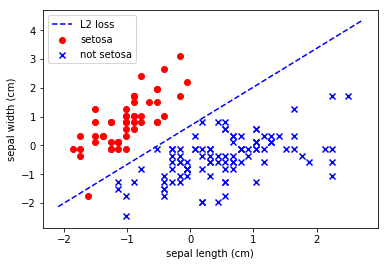

In [15]:
plt.scatter(X[y == 0, 0], X[y == 0, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[y != 0, 0], X[y != 0, 1],
            color='blue', marker='x', label='not setosa')

# Plot the three one-against-all classifiers
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
coef = clf.coef_
intercept = clf.intercept_

def plot_hyperplane(c, color, label):
    def line(x0):
        return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]

    plt.plot([xmin, xmax], [line(xmin), line(xmax)],
             ls="--", color=color, label=label)


plot_hyperplane(0, 'b', "L2 loss")

plt.xlabel(feat[0])
plt.ylabel(feat[1])
plt.legend(loc='upper left')
plt.show()

Not too bad.

### Tasks

- Try altering the values of eta and the number of iterations

We don't use any regularization here, because we only have two features. This would be far more
important when we had multiple features.

# Logistic Regression

Welcome! This workshop is from [TrainingDataScience.com](https://trainingdatascience.com/?utm_source=trainingdatascience&utm_medium=notebook&utm_campaign=workshop&utm_term=individual). Sign up to receive more free workshops, training and videos.

I find the name logistic regression annoying. We don't normally use logistic regression for anything other than classification; but statistics coined the name long ago.

Despite the name, logistic regression is incredibly useful. Instead of optimising the error of the distance like we did in standard [linear regression](https://trainingdatascience.com/workshops/linear-classification/), we can frame the problem probabilistically. Logistic regression attempts to separate classes based upon the probability that an observation belongs to a class.

In [16]:
# Usual imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn import datasets
from sklearn import preprocessing

In [17]:
# import some data to play with
iris = datasets.load_iris()
feat = iris.feature_names
X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = iris.target
y[y != 0] = 1 # Only use two targets for now
colors = "bry"

# standardize
X = preprocessing.StandardScaler().fit_transform(X)

Of course, SKLearn has an implementation of logistic regression and it uses the usual `fit` API.

In [18]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression().fit(X, y)

Because I want to show probability contours, the plotting code is a bit more complicated than usual.

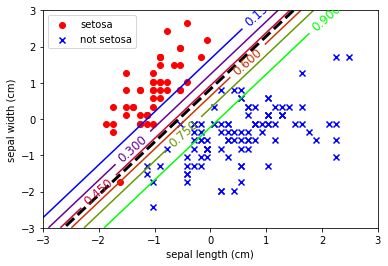

In [19]:
# Create a grid of points then calculate the probability at each point. This creates a "mesh" of points.
x0, x1 = np.meshgrid(
        np.linspace(-3, 3, 500).reshape(-1, 1),
        np.linspace(-3, 3, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.scatter(X[y == 0, 0], X[y == 0, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[y != 0, 0], X[y != 0, 1],
            color='blue', marker='x', label='not setosa')

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([-3, 3])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.xlabel(feat[0])
plt.ylabel(feat[1])
plt.legend(loc='upper left')
plt.axis([-3,3,-3,3])
plt.show()

Note the probability estimates in the contours. This is an incredibly useful trait. To provide class estimates with an estimate to show how likely that observation is to really be part of that class.

But always remember that these estimates are based upon a gaussian fit of the data. If the data isn't representative or it isn't normally distributed, then these estimates will be erroneous in some way.

## Tasks

- Try predicting the probability manually for a few points on either side of the line. (See above, the line that uses `log_reg.predict_proba`)

# Support Vector Machines

Welcome! This workshop is from [TrainingDataScience.com](https://trainingdatascience.com/?utm_source=trainingdatascience&utm_medium=notebook&utm_campaign=workshop&utm_term=individual). Sign up to receive more free workshops, training and videos.

If you remember from the video training, SVMs are classifiers that attemt to maximise the separation between classes, no matter what the distribution of the data. This means that they can sometimes fit noise more than they fit the data.

But because they are aiming to separate classes, they do a really good job at optimising for accuracy. Let's investigate this below.

In [20]:
# Usual imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn import datasets
from sklearn import preprocessing

In [21]:
# import some data to play with
iris = datasets.load_iris()
feat = iris.feature_names
X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = iris.target
y[y != 0] = 1 # Only use two targets for now
colors = "bry"

# standardize
X = preprocessing.StandardScaler().fit_transform(X)

In [22]:
from sklearn.svm import SVC
# Create a linear SVM
svm_clf = SVC(kernel='linear', C=float("inf")).fit(X, y)

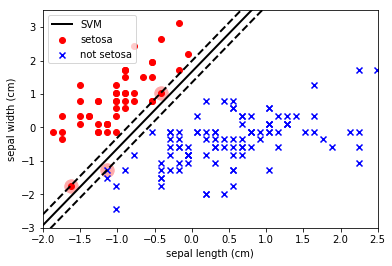

In [23]:
# A fairly complicated function to plot the decision boundary and separation found by a liner SVM.
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2, label="SVM")
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

# Usual plotting related stuff.
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.scatter(X[y == 0, 0], X[y == 0, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[y != 0, 0], X[y != 0, 1],
            color='blue', marker='x', label='not setosa')
plt.axis([-2, 2.5, -3, 3.5])
plt.xlabel(feat[0])
plt.ylabel(feat[1])
plt.legend(loc='upper left')
plt.show()

Note how the SVM has maximised the separation between the classes and also allowed some datapoints to enter within the boundary. The SVM parameter `C` is a penalty parameter that specifies whether it should force the separation of the classes (`C=inf`) or allow some points to be misclassified to obtain a better fit (`C=small`).

Let's allow some level of misclassification to get a better (IMO) decision boundary:

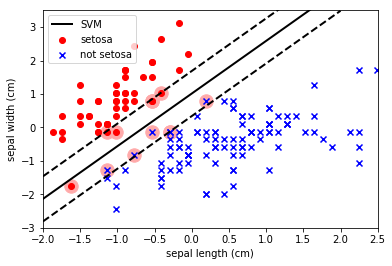

In [24]:
svm_clf = SVC(kernel='linear', C=1.0).fit(X, y)
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.scatter(X[y == 0, 0], X[y == 0, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[y != 0, 0], X[y != 0, 1],
            color='blue', marker='x', label='not setosa')
plt.axis([-2, 2.5, -3, 3.5])
plt.xlabel(feat[0])
plt.ylabel(feat[1])
plt.legend(loc='upper left')
plt.show()

## Kernel Trick

Remember that it is [possible to transform the input data](https://trainingdatascience.com/workshops/histograms-and-skewed-data/) without compromising the integrity of the data. The transformation simply needs to be invertible. The "kernel trick" is a method to transform the data by a complex (invertible) function to allow more complex decision boundaries.

When we preform this trick with SVMs the result is a Kernel SVM. In the next example we choose a _radial basis function_ for our kernel. This is basically a multi-dimensional gaussian. We specify the width of this kernel with the `gamma` parameter. Smaller values of `gamma` will produce more complex boundaries (less smoothing).

In [25]:
from sklearn.svm import SVC
# This is a Support vector machine with a "radial basis function" kernel.
# One issue with SVMs is that they are quite complex to tune, because of all the different parameters.
rbf_svc = SVC(kernel='rbf', gamma=0.7, C=float('inf')).fit(X, y)

In [26]:
from matplotlib.colors import ListedColormap

# A fancy method to plot the decision regions of complex decision boundaries
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02, labels=['setosa', 'not setosa'], X_plot=None):

    if X_plot is None:
        X_plot = X
    
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                         np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot all samples
    X_test, y_test = X[test_idx, :], y[test_idx]                               
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=labels[cl])
        
    # highlight test samples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]   
        plt.scatter(X_test[:, 0], X_test[:, 1], c='', 
                alpha=1.0, linewidth=1, marker='o', 
                s=55, label='test set')

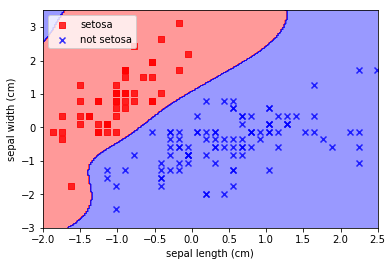

In [27]:
plot_decision_regions(X=X, y=y, classifier=rbf_svc)
plt.xlabel(feat[0])
plt.ylabel(feat[1])
plt.legend(loc='upper left')

plt.axis([-2, 2.5, -3, 3.5])
plt.show()

Note how insane that decision boundary is. To the extent that the algorithm has "invented" a blue decision region at the top left where there is absolutely no evidence that it should be there. This is the risk of choosing such arbitrary decision boundaries; arbitrary results.

### Bonus Tasks:

- Try testing different classification models. Namely:
  - `SVC(kernel='linear'...`
  - `linear_model.RidgeClassifier`
  - `linear_model.Lasso`